In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve,auc
import statsmodels.api as sm
from scipy.stats import chi2_contingency

file_path = '/content/drive/MyDrive/MARJANTA_DATA.csv'

df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Display the first few rows of the dataframe
df.head()



,Ref,id,Gender,Satisfied,Age,Age Band,Type of Travel,Class,Flight Distance,Destination,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,0,70172,Male,Y,13,Under 18,Personal Travel,Eco Plus,4760,India,...,5,5,4,3,4,4,5,5,25,18.0
1,1,5047,Male,N,25,25 to 34,Business travel,Business,235,Republic of Ireland,...,1,1,1,5,3,1,4,1,1,6.0
2,2,110028,Female,Y,26,25 to 34,Business travel,Business,4760,India,...,5,5,4,3,4,4,4,5,0,0.0
3,3,24026,Female,Y,25,25 to 34,Business travel,Business,560,Norway,...,2,2,2,5,3,1,4,2,11,9.0
4,4,119299,Male,Y,61,55 to 64,Business travel,Business,4760,India,...,5,3,3,4,4,3,3,3,0,0.0


**Mapping columns**

In [ ]:
# Function to map and standardize columns
def map_columns(df):
    # Map 'Age Band' to an ordered categorical type with new labels like '18-24'
    age_band_order = ['Under 18', '18-24', '25-34', '35-44', '45-54', '55-64', '65 or over']
    df['Age Band'] = df['Age Band'].replace({
        'Under 18': 'Under 18',
        '18 to 24': '18-24',
        '25 to 34': '25-34',
        '35 to 44': '35-44',
        '45 to 54': '45-54',
        '55 to 64': '55-64',
        '65 or over': '65 or over'
    })
    df['Age Band'] = pd.Categorical(df['Age Band'], categories=age_band_order, ordered=True)

    # Convert 'Satisfied' from 'Y', 'N' to 'Yes', 'No'
    df['Satisfied'] = df['Satisfied'].replace({'Y': 'Yes', 'N': 'No'}).astype('category')

    # Standardize 'Continent' by replacing 'Europe/Asia' with 'Eurasia'
    df['Continent'] = df['Continent'].replace('Europe/Asia (Eurasia)', 'Eurasia').astype('category')

    return df

# Apply the cleaning function to the dataframe
df = map_columns(df)

# Display the first few rows of the cleaned dataframe
print(df.head())


   Ref      id  Gender Satisfied  Age  Age Band   Type of Travel     Class  \
0    0   70172    Male       Yes   13  Under 18  Personal Travel  Eco Plus   
1    1    5047    Male        No   25     25-34  Business travel  Business   
2    2  110028  Female       Yes   26     25-34  Business travel  Business   
3    3   24026  Female       Yes   25     25-34  Business travel  Business   
4    4  119299    Male       Yes   61     55-64  Business travel  Business   

   Flight Distance          Destination  ... Seat comfort  \
0             4760                India  ...            5   
1              235  Republic of Ireland  ...            1   
2             4760                India  ...            5   
3              560               Norway  ...            2   
4             4760                India  ...            5   

   Inflight entertainment  On-board service  Leg room service  \
0                       5                 4                 3   
1                       1         

**Cleaning**

In [ ]:
def clean_data(df):

    # 1. Handling Duplicates
    num_duplicates = df.duplicated().sum()
    if num_duplicates > 0:
        print(f"Number of duplicate rows before cleaning: {num_duplicates}")
        df = df.drop_duplicates()
        print("Duplicates removed.")
        print(f"Number of duplicate rows after cleaning: {df.duplicated().sum()}")
    else:
        print("No duplicates found.")

    # 2. Identify Missing Values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values detected in the following columns:")
        print(missing_values[missing_values > 0])
    else:
        print("No missing values found.")

    # 3. Identify Column Types
    integer_columns = df.select_dtypes(include=['int64']).columns
    float_columns = df.select_dtypes(include=['float64']).columns
    object_columns = df.select_dtypes(include=['object']).columns

    # 4. Handling Missing Values
    # Handle integer columns
    for column in integer_columns:
        if missing_values[column] > 0:
            df[column] = df[column].fillna(df[column].median()).astype(int)

    # Handle float columns
    for column in float_columns:
        if missing_values[column] > 0:
            df[column] = df[column].fillna(df[column].median())

    # Handle categorical and string columns
    for column in object_columns:
        if missing_values[column] > 0:
            df[column] = df[column].fillna(df[column].mode().iloc[0])

    # Convert 'Departure Delay in Minutes' to float
    if 'Departure Delay in Minutes' in df.columns:
        df['Departure Delay in Minutes'] = df['Departure Delay in Minutes'].astype(float)

    # 5. Standardizing 'Type of Travel' and 'Class' columns
    if 'Type of Travel' in df.columns:
        df['Type of Travel'] = df['Type of Travel'].str.strip().str.lower().replace({
            'personal travel': 'personal',
            'business travel': 'business'
        })

    if 'Class' in df.columns:
        df['Class'] = df['Class'].str.strip().str.lower().replace({
            'eco': 'economy',
            'eco plus': 'economy plus',
            'business': 'business'
        })


    # 6. Outlier Detection and Handling for Numerical Columns
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns
    for column in numerical_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        num_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
        if num_outliers > 0:
            print(f"Outliers detected in '{column}': {num_outliers}")
            df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
            df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
            print(f"Outliers in '{column}' have been handled.")
        else:
            print(f"No outliers found in '{column}'.")

    return df


# Apply the cleaning function to the dataframe
df = clean_data(df)

# Display the first few rows of the cleaned dataframe
print("\nCleaned DataFrame:")
print(df.head())


No duplicates found.

Missing values detected in the following columns:
Arrival Delay in Minutes    310
dtype: int64
No outliers found in 'Ref'.
No outliers found in 'id'.
No outliers found in 'Age'.
Outliers detected in 'Flight Distance': 19972
Outliers in 'Flight Distance' have been handled.
No outliers found in 'Inflight wifi service'.
No outliers found in 'Departure/Arrival time convenient'.
No outliers found in 'Ease of Online booking'.
No outliers found in 'Gate location'.
No outliers found in 'Food and drink'.
No outliers found in 'Online boarding'.
No outliers found in 'Seat comfort'.
No outliers found in 'Inflight entertainment'.
No outliers found in 'On-board service'.
No outliers found in 'Leg room service'.
No outliers found in 'Baggage handling'.
Outliers detected in 'Checkin service': 12894
Outliers in 'Checkin service' have been handled.
No outliers found in 'Inflight service'.
No outliers found in 'Cleanliness'.
Outliers detected in 'Departure Delay in Minutes': 14529
O

**Descriptive analysis**

Total Number of Passengers: 103904
Average Age of Passengers: 39.38
Median Age of Passengers: 40.00
Standard Deviation of Age: 15.11
Average Flight Distance: 4760.00

Satisfaction Distribution:


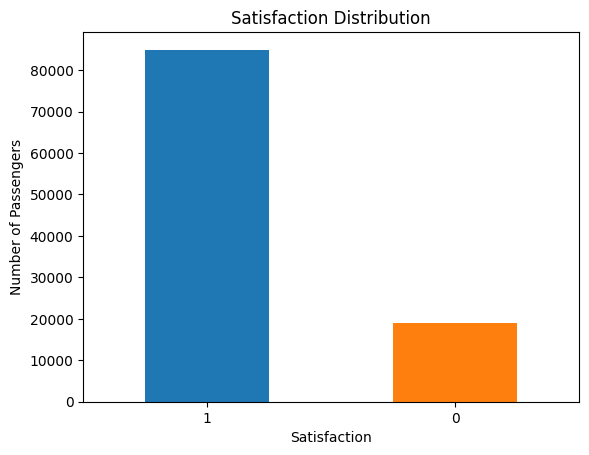


Satisfaction by Gender:


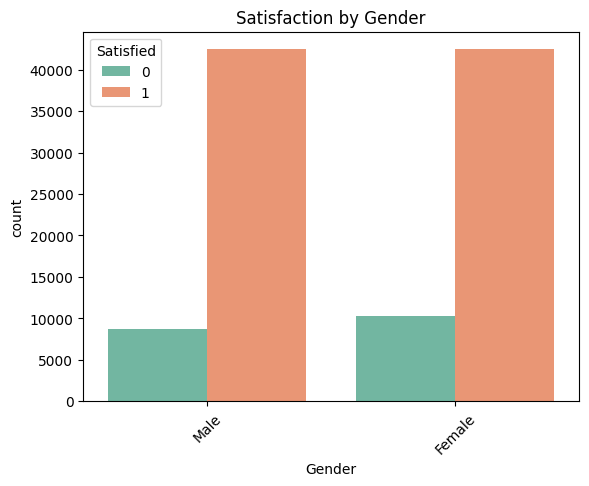


Satisfaction by Age Band:


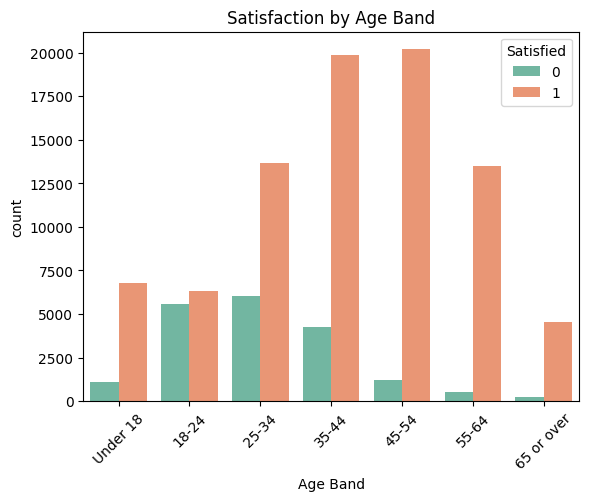


Satisfaction by Type of Travel:


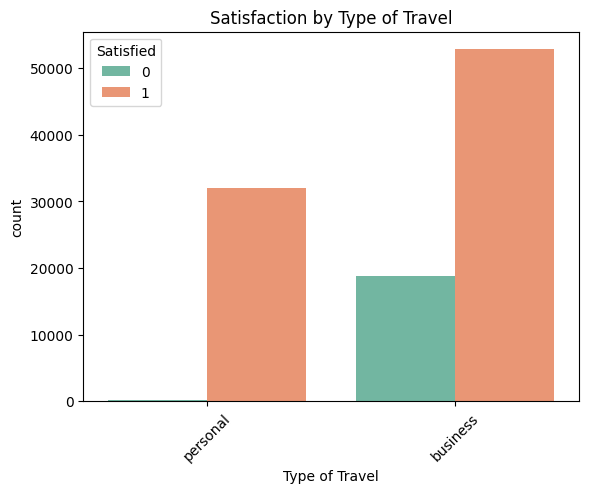


Satisfaction by Class:


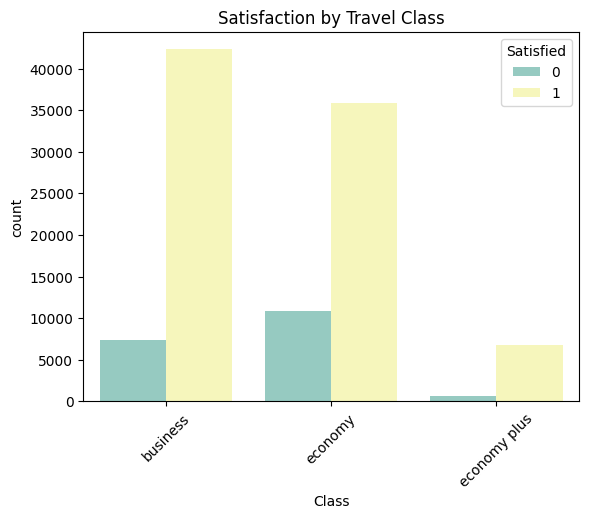


Average Ratings of Services:
Seat comfort              3.398666
Inflight entertainment    3.358071
Cleanliness               3.286245
Inflight wifi service     2.522319
Food and drink            3.202023
Leg room service          3.350930
On-board service          3.382247
Checkin service           3.366271
Baggage handling          3.631708
dtype: float64


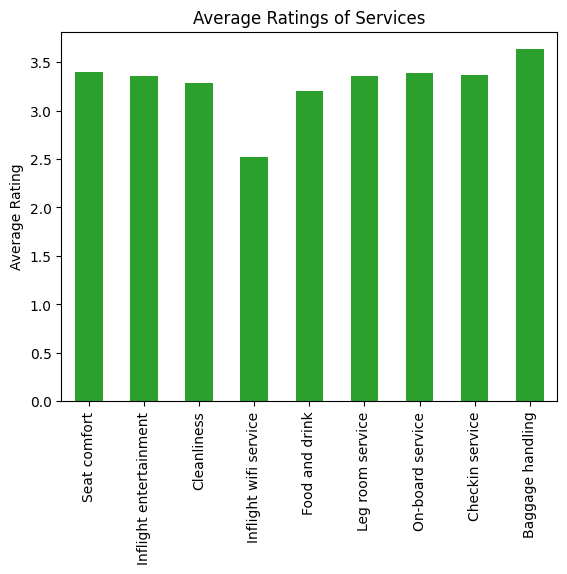


Correlation of Service Ratings with Satisfaction:
Seat comfort              0.144701
Inflight entertainment    0.110071
Cleanliness               0.083750
Inflight wifi service     0.309855
Food and drink            0.059589
Leg room service          0.048006
On-board service          0.056705
Checkin service           0.032013
Baggage handling         -0.024539
Name: Satisfied, dtype: float64


<ipython-input-6-75d4a80ded81>:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


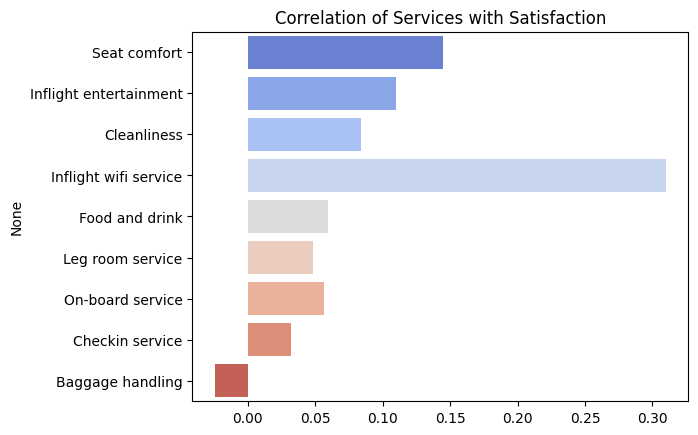


Distribution of Service Ratings (Boxplot):


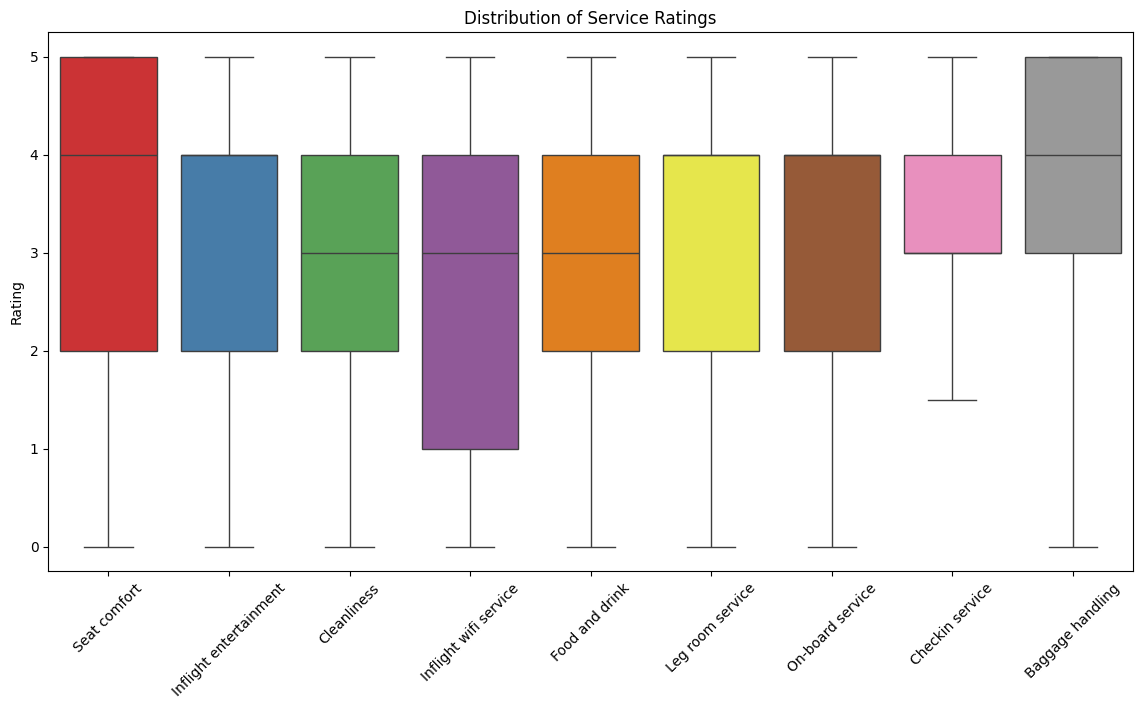


Passenger Age Distribution:


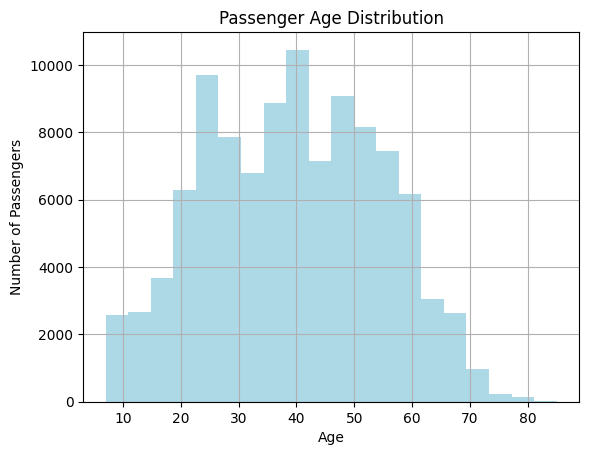

In [ ]:
def combined_descriptive_analysis(df, save_plots=False, output_dir="plots"):
    # Work with a copy of the DataFrame to avoid modifying the original data
    df_copy = df.copy()

    # Ensure output directory exists
    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 1. Check if 'Satisfied' and 'Class' columns exist
    required_columns = ['Satisfied', 'Class']
    missing_columns = [col for col in required_columns if col not in df_copy.columns]

    if missing_columns:
        print(f"Error: Missing columns in the dataset: {missing_columns}")
        return  # Stop execution if required columns are missing

    # 2. Handle Missing Data for critical columns only in the copy
    df_copy = df_copy.dropna(subset=['Satisfied', 'Class'])  # Only drop rows where 'Satisfied' or 'Class' is NaN

    # 3. Convert 'Satisfied' column safely in the copy
    df_copy['Satisfied'] = df_copy['Satisfied'].map({'Yes': 1, 'No': 0})

    # 4. Total Number of Passengers
    total_passengers = len(df_copy)
    print(f"Total Number of Passengers: {total_passengers}")

    # 5. Average Passenger Age and Flight Distance
    average_age = df_copy['Age'].mean()
    median_age = df_copy['Age'].median()
    std_age = df_copy['Age'].std()
    average_flight_distance = df_copy['Flight Distance'].mean()
    print(f"Average Age of Passengers: {average_age:.2f}")
    print(f"Median Age of Passengers: {median_age:.2f}")
    print(f"Standard Deviation of Age: {std_age:.2f}")
    print(f"Average Flight Distance: {average_flight_distance:.2f}")

    # 6. Satisfaction Distribution
    print("\nSatisfaction Distribution:")
    satisfaction_counts = df_copy['Satisfied'].value_counts()
    satisfaction_counts.plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
    plt.title('Satisfaction Distribution')
    plt.xlabel('Satisfaction')
    plt.ylabel('Number of Passengers')
    plt.xticks(rotation=0)
    if save_plots:
        plt.savefig(os.path.join(output_dir, "satisfaction_distribution.png"))
    plt.show()

    # 7. Satisfaction by Demographics (Gender, Age Band, Type of Travel)
    demographics = ['Gender', 'Age Band', 'Type of Travel']
    for demographic in demographics:
        if demographic in df_copy.columns:
            print(f"\nSatisfaction by {demographic}:")
            sns.countplot(data=df_copy, x=demographic, hue='Satisfied', palette='Set2')
            plt.title(f'Satisfaction by {demographic}')
            plt.xticks(rotation=45)
            if save_plots:
                plt.savefig(os.path.join(output_dir, f"satisfaction_by_{demographic.lower().replace(' ', '_')}.png"))
            plt.show()
        else:
            print(f"Warning: '{demographic}' column not found, skipping plot.")

    # 8. Satisfaction by Class
    print("\nSatisfaction by Class:")
    sns.countplot(data=df_copy, x='Class', hue='Satisfied', order=df_copy['Class'].value_counts().index, palette='Set3')
    plt.title('Satisfaction by Travel Class')
    plt.xticks(rotation=45)
    if save_plots:
        plt.savefig(os.path.join(output_dir, "satisfaction_by_class.png"))
    plt.show()

    # 9. Average Ratings of Services
    service_columns = [
        'Seat comfort', 'Inflight entertainment', 'Cleanliness',
        'Inflight wifi service', 'Food and drink', 'Leg room service',
        'On-board service', 'Checkin service', 'Baggage handling'
    ]
    average_ratings = df_copy[service_columns].mean()
    print("\nAverage Ratings of Services:")
    print(average_ratings)
    average_ratings.plot(kind='bar', color='#2ca02c')
    plt.title('Average Ratings of Services')
    plt.ylabel('Average Rating')
    if save_plots:
        plt.savefig(os.path.join(output_dir, "average_ratings_of_services.png"))
    plt.show()

    # 10. Correlation of Services with Satisfaction
    print("\nCorrelation of Service Ratings with Satisfaction:")
    correlations = df_copy[service_columns + ['Satisfied']].corr()['Satisfied'].drop('Satisfied')
    print(correlations)
    sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
    plt.title('Correlation of Services with Satisfaction')
    if save_plots:
        plt.savefig(os.path.join(output_dir, "correlation_of_services_with_satisfaction.png"))
    plt.show()

    # 11. Maximum and Minimum Ratings (Boxplot) with Adjustments
    print("\nDistribution of Service Ratings (Boxplot):")
    plt.figure(figsize=(14, 7))  # Increase figure size for better readability
    sns.boxplot(data=df_copy[service_columns], palette='Set1')
    plt.title('Distribution of Service Ratings')
    plt.ylabel('Rating')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    if save_plots:
        plt.savefig(os.path.join(output_dir, "distribution_of_service_ratings.png"))
    plt.show()

    # 12. Passenger Age Distribution
    print("\nPassenger Age Distribution:")
    df_copy['Age'].hist(bins=20, color='lightblue')
    plt.title('Passenger Age Distribution')
    plt.xlabel('Age')
    plt.ylabel('Number of Passengers')
    if save_plots:
        plt.savefig(os.path.join(output_dir, "passenger_age_distribution.png"))
    plt.show()

combined_descriptive_analysis(df, save_plots=True, output_dir="descriptive_stats_plots")


**Inferential**

In [ ]:
# Prepare the target variable
df['Satisfied'] = df['Satisfied'].replace({'Yes': 1, 'No': 0})

# Select relevant features
service_columns = [
    'Seat comfort', 'Inflight entertainment', 'Cleanliness',
    'Inflight wifi service', 'Food and drink', 'Leg room service',
    'On-board service', 'Checkin service', 'Baggage handling'
]

# Define features (X) and target (y)
X = df[service_columns]
y = df['Satisfied']

# Split data into training+validation set and test set (80% train+val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split training+validation set further into training set and validation set (75% train, 25% validation)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Print the shape of each dataset to verify
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)


Training set shape: (62342, 9) (62342,)
Validation set shape: (20781, 9) (20781,)
Test set shape: (20781, 9) (20781,)


In [ ]:
# Add a constant to include an intercept in the model
X_train_const = sm.add_constant(X_train)

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# Print the summary for inferential statistics
print(result.summary())

# Hypothesis Testing:
# - If the p-value of a coefficient is < 0.05,  reject the null hypothesis for that service rating,
#   indicating that it significantly impacts passenger satisfaction.


Optimization terminated successfully.
         Current function value: 0.414554
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Satisfied   No. Observations:                62342
Model:                          Logit   Df Residuals:                    62332
Method:                           MLE   Df Model:                            9
Date:                Sun, 01 Sep 2024   Pseudo R-squ.:                  0.1281
Time:                        14:43:32   Log-Likelihood:                -25844.
converged:                       True   LL-Null:                       -29641.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0.2463      0.055     -4.490      0.000      -0.354      

In [ ]:
# Chi-Square Test between 'Satisfied' and 'Class'
contingency_table_class = pd.crosstab(df['Satisfied'], df['Class'])
chi2_stat_class, p_value_class, dof_class, expected_class = chi2_contingency(contingency_table_class)

print('Chi-square statistic for Satisfied vs Class:', chi2_stat_class)
print('p-value for Satisfied vs Class:', p_value_class)

# Chi-Square Test between 'Satisfied' and 'Type of Travel'
contingency_table_travel = pd.crosstab(df['Satisfied'], df['Type of Travel'])
chi2_stat_travel, p_value_travel, dof_travel, expected_travel = chi2_contingency(contingency_table_travel)

print('Chi-square statistic for Satisfied vs Type of Travel:', chi2_stat_travel)
print('p-value for Satisfied vs Type of Travel:', p_value_travel)

# Interpretation:
# - If p-value < 0.05, reject the null hypothesis, suggesting a significant association between the variables.


Chi-square statistic for Satisfied vs Class: 1584.5133116576426
p-value for Satisfied vs Class: 0.0
Chi-square statistic for Satisfied vs Type of Travel: 9874.91420227069
p-value for Satisfied vs Type of Travel: 0.0


**Model Training**

In [ ]:
# Define reusable function for feature engineering
def feature_engineering(df, service_columns, categorical_features):
    # Create interaction term
    df['SeatComfort_WifiInteraction'] = df['Seat comfort'] * df['Inflight wifi service']

    # Select features
    X = df[service_columns + ['SeatComfort_WifiInteraction'] + categorical_features]
    y = df['Satisfied']

    return X, y

# Define reusable function to create preprocessing pipeline
def create_preprocessor(service_columns, categorical_features):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), service_columns + ['SeatComfort_WifiInteraction']),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ]
    )
    return preprocessor

from sklearn.preprocessing import LabelEncoder

def build_and_evaluate_model(df, service_columns, categorical_features, model):
    # Feature engineering
    X, y = feature_engineering(df, service_columns, categorical_features)

    # Encode the labels to 0 and 1
    le = LabelEncoder()
    y = le.fit_transform(y)

    # Preprocessing
    preprocessor = create_preprocessor(service_columns, categorical_features)

    # Build pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    pipeline.fit(X_train, y_train)

    # Predict and evaluate
    y_test_pred = pipeline.predict(X_test)
    y_test_prob = pipeline.predict_proba(X_test)[:, 1]  # Get predicted probabilities
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_prob)

    # Return the necessary variables for further evaluation
    return y_test, y_test_prob, test_accuracy, test_auc


# Define the service columns and categorical features
service_columns = [
    'Seat comfort', 'Inflight entertainment', 'Cleanliness',
    'Inflight wifi service', 'Food and drink', 'Leg room service',
    'On-board service', 'Checkin service', 'Baggage handling'
]
categorical_features = ['Class', 'Type of Travel', 'Gender']



Random Forest Test Accuracy with Feature Engineering: 0.96
Random Forest Test AUC with Feature Engineering: 0.98


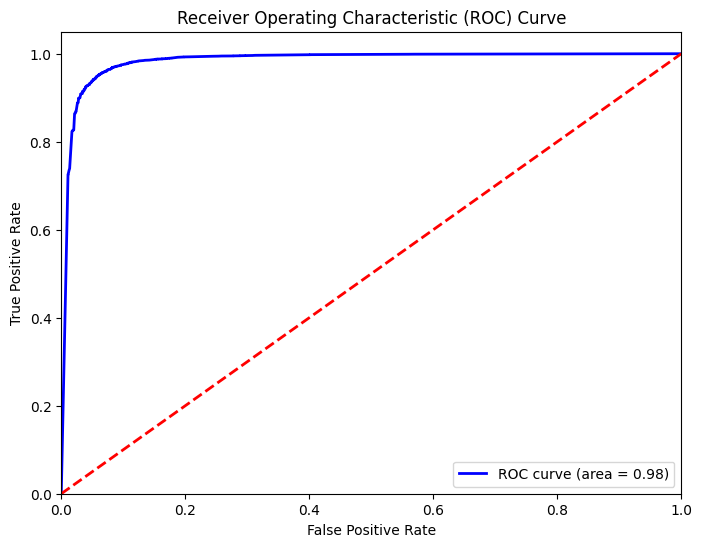

In [ ]:
# Evaluate RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
y_test, y_test_prob, rf_accuracy, rf_auc = build_and_evaluate_model(df, service_columns, categorical_features, rf_model)
print(f"Random Forest Test Accuracy with Feature Engineering: {rf_accuracy:.2f}")
print(f"Random Forest Test AUC with Feature Engineering: {rf_auc:.2f}")

# Generate ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


AdaBoost Test Accuracy with Feature Engineering: 0.92
AdaBoost Test AUC with Feature Engineering: 0.96


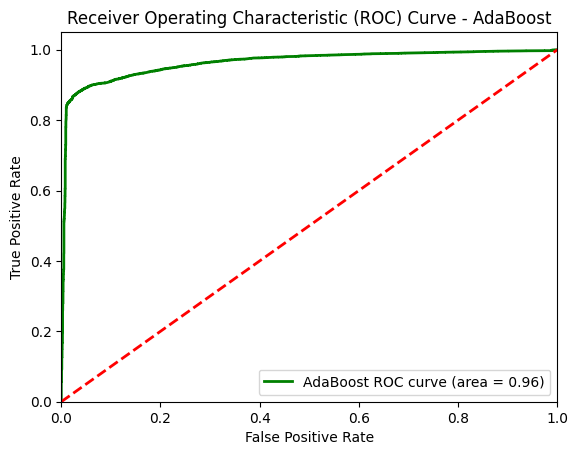

In [ ]:
# Evaluate AdaBoost model
ab_model = AdaBoostClassifier(n_estimators=100, random_state=42)
y_test_ab, y_test_prob_ab, ab_accuracy, ab_auc = build_and_evaluate_model(df, service_columns, categorical_features, ab_model)
print(f"AdaBoost Test Accuracy with Feature Engineering: {ab_accuracy:.2f}")
print(f"AdaBoost Test AUC with Feature Engineering: {ab_auc:.2f}")

# Generate ROC Curve for AdaBoost
fpr_ab, tpr_ab, thresholds_ab = roc_curve(y_test_ab, y_test_prob_ab)
roc_auc_ab = auc(fpr_ab, tpr_ab)

plt.figure()
plt.plot(fpr_ab, tpr_ab, color='green', lw=2, label=f'AdaBoost ROC curve (area = {roc_auc_ab:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - AdaBoost')
plt.legend(loc="lower right")
plt.show()